In [1]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import ipywidgets as widgets
from IPython import display

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sys
sys.path.append('/h/ashlie/jupyter_helpers')
import plot_helper as ph

import os

In [4]:
objs = []

In [5]:
# time ms in msec, latency us in nsec.
base_path = '/h/ashlie/new-benchmark-timed-submit'
op_types = [
    #'read',
    #'randread',
    'write',
    #'randwrite',
]
queue_sizes = [
    #1,
    #2,
    #4,
    #8,
    #16,
    #32,
    #64,
    #128,
    #256,
    #512,
    #1024,
    #2048,
    4096,
]
latf = '_lat.log'

devs = {
    #'spdk',
    #'spdk_delay',
    'spdk_batch',
    #'spdk_delay_batch',
    #'spdk_optane',
    #'spdk_optane_delay',
    'spdk_optane_batch',
    #'spdk_optane_delay_batch',
    #'sync',
    #'sync_force_sync',
    #'sync_ramdisk',
}

blk_sizes = {
    512,
    #1024,
    #2048,
    #4096,
}

# TODO(t-asmart): Make this easier to handle without having to clobber objs.
for op in op_types:
    for qs in queue_sizes:
        for dev in devs:
            for bs in blk_sizes:
                objs.append({
                    'op': op,
                    'queueSize': qs,
                    'blockSize': bs,
                    'device': dev,
                    'filePath': os.path.join(
                                    os.path.join(
                                        os.path.join(
                                            os.path.join(
                                                os.path.join(base_path, op),
                                                'q' + str(qs)),
                                            dev),
                                        'bs' + str(bs)),
                                    latf)
                })

# Total time in sec
total_time = 10
bytes_per_mb = 1024 ** 2

large_fig_dim = (15, 10.6)

In [6]:
for obj in objs:
    obj['df'] = pd.read_csv(obj['filePath'], sep=',', names=['latency (ns)'])

In [7]:
for obj in objs:
    print obj['device'] + '\n' + str(obj['df'].describe())

spdk_batch
         latency (ns)
count  1000000.000000
mean         1.012496
std          0.111597
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
spdk_optane_batch
         latency (ns)
count  1000000.000000
mean         1.327682
std          5.438846
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        128.000000


In [20]:
objs[1]['df'][objs[1]['df']['latency (ns)'] > 127].count()

latency (ns)    1280
dtype: int64

In [27]:
objs[1]['df']['latency (ns)'].quantile(q=0.998)

88.0

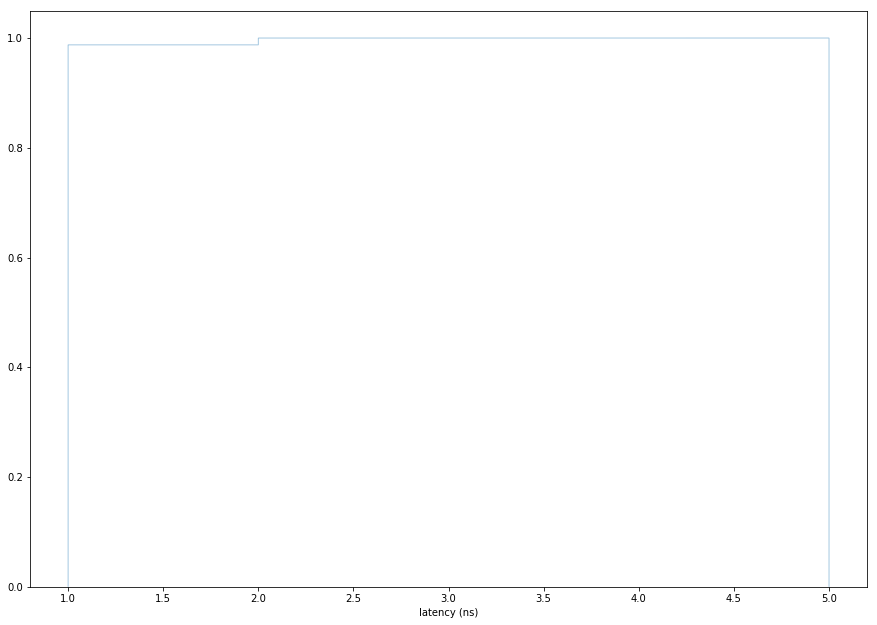

In [16]:
figSubmitLat, axesSubmitLat = plt.subplots(figsize=large_fig_dim)
sns.distplot(objs[0]['df']['latency (ns)'], kde=False, hist=True, rug=False, bins=1000000,
             hist_kws={'histtype': 'step', 'density': True, 'cumulative': True})

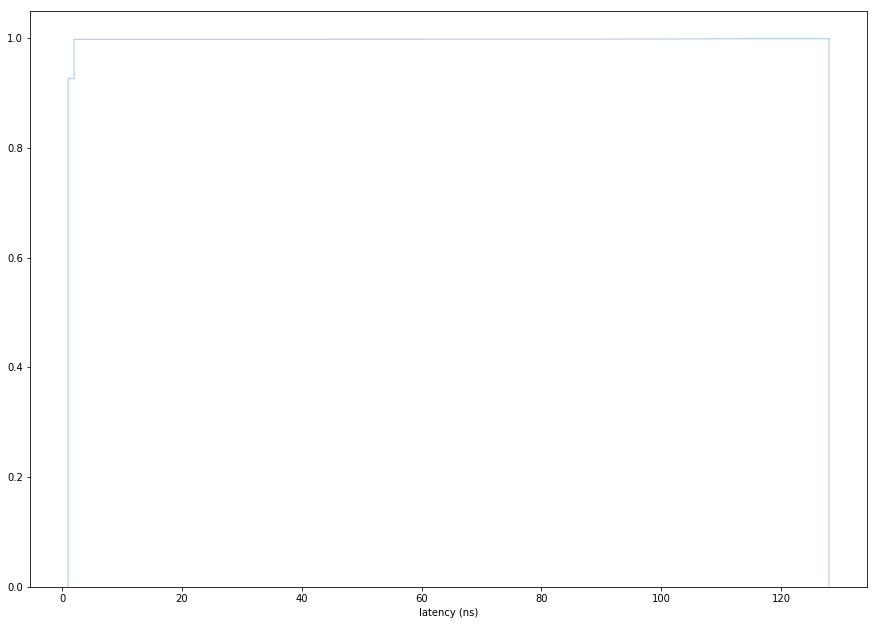

In [15]:
figSubmitLat, axesSubmitLat = plt.subplots(figsize=large_fig_dim)
sns.distplot(objs[1]['df']['latency (ns)'], kde=False, hist=True, rug=False, bins=1000000,
             hist_kws={'histtype': 'step', 'density': True, 'cumulative': True})

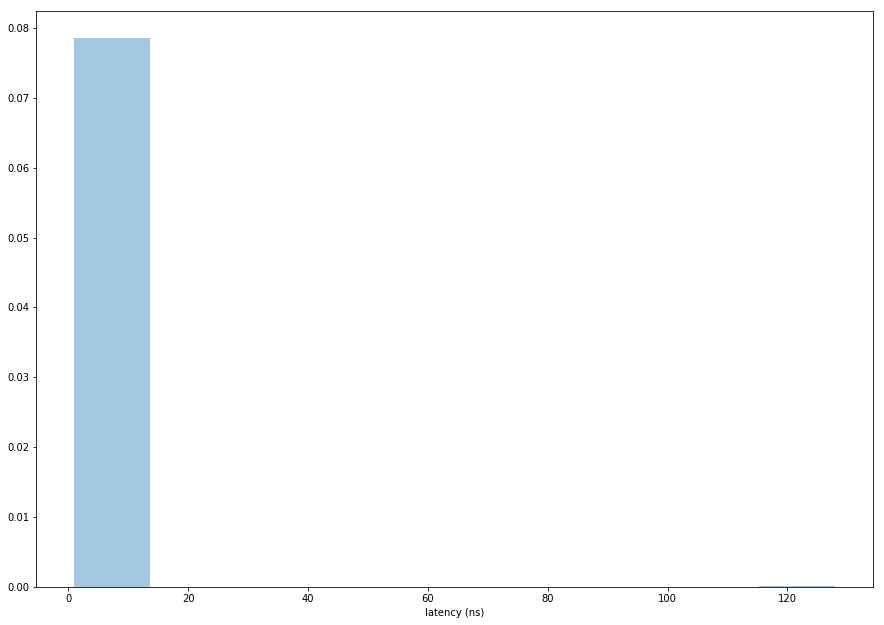

In [33]:
figSubmitLat, axesSubmitLat = plt.subplots(figsize=large_fig_dim)
sns.distplot(objs[1]['df']['latency (ns)'], kde=False, hist=True, rug=False, bins=10,
             hist_kws={'histtype': 'bar', 'density': True, 'cumulative': False})

In [9]:
submitLat = {}
for op in op_types:
    submitLat[op] = pd.DataFrame()
    for obj in objs:
        if obj['op'] != op:
            continue
        tmp = obj['df'].sample(n=500, random_state=42)
        tmp['Device'] = obj['device']
        tmp['latency (us)'] = tmp['latency (ns)'] / 1000
        tmp.drop(columns=['latency (ns)'], inplace=True)
        submitLat[op] = submitLat[op].append(tmp)

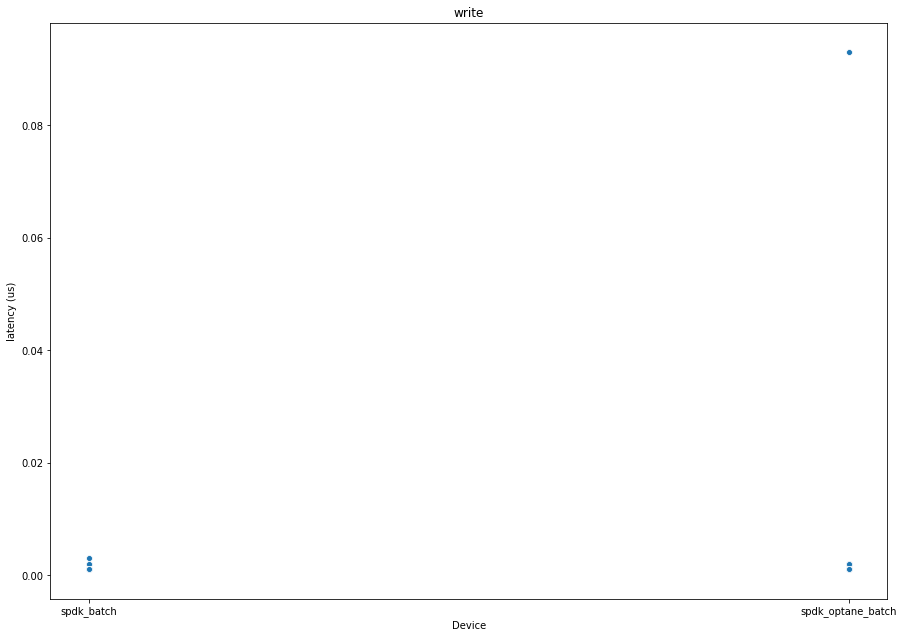

In [11]:
figSubmitLat, axesSubmitLat = plt.subplots(nrows=len(submitLat), ncols=1,
                                       figsize=(large_fig_dim[0], large_fig_dim[1] * len(submitLat)))
row = 0
for k, p in submitLat.iteritems():
    sns.scatterplot(x='Device', y='latency (us)', data=p,
                 ax=axesSubmitLat)
    #axesLatVCQd[row].set_xscale('log', basex=2)
    axesSubmitLat.set_title(k)
    row += 1